# Model przewidujący wystąpienie zawału

Celem projektu jest stworzenie modelu, który z wykorzystaniem algorytmów uczenia maszynowego będzie w stanie określić możliwość wystąpienia zawału u pacjenta.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
healthcare = pd.read_csv("healthcare-dataset-stroke-data.csv")

Wczytujemy dataset, następnie sprawdzamy jego właściwości

In [59]:
healthcare.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Opis kolumn:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

Opuszczamy kolumnę "id", nie będzie potrzebna do analizy.

In [4]:
healthcare = healthcare.drop(["id"], axis=1)

In [5]:
healthcare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Braki znajdują się tylko w kolumnie BMI, będziemy mogli usunąć wiersze z brakującymi elementami, wstawić wartość średnią/medianę, lub zastosować algorytm do uzupełnienia braków - np. k-najbliższych sąsiadów. Większość kolumn zawiera zmienne opisowe, będziemy musieli zastosować enkoder w celu zmiany ich w zmienne liczbowe - np. ordinal encoder.

In [6]:
healthcare.describe(include="all")

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [7]:
obj = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
num = ["age", "avg_glucose_level", "bmi"]

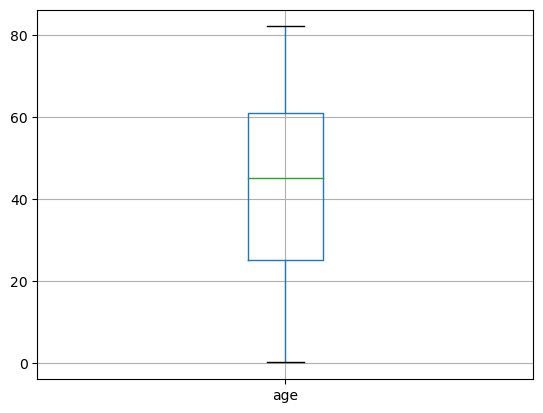

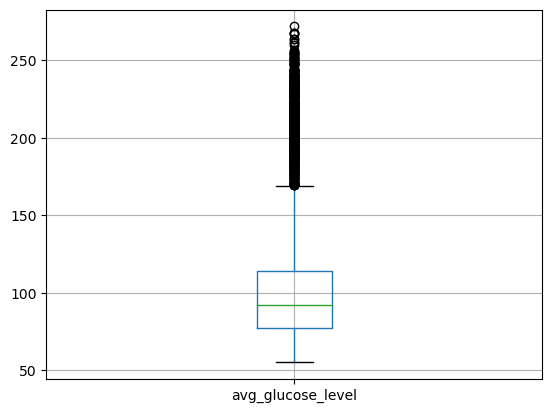

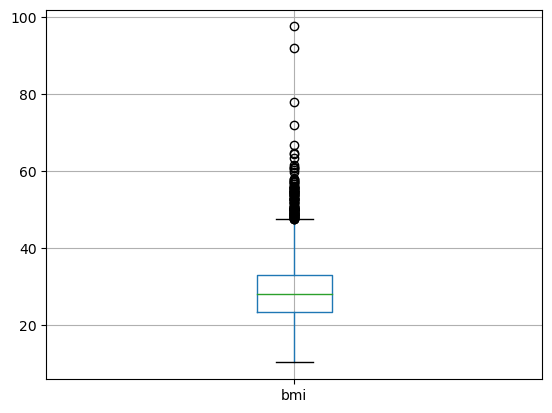

In [8]:
for col in num:
    plt.figure()
    healthcare.boxplot([col])

Mamy dużą liczbę wartości odstających, jednak nie są one niemożliwe, a ze względu na szukanie potencjalnych zawałów, mogą być one potrzebne do budowy skutecznego modelu.

Sprawdzamy, czy w kolumnach z danymi opisowymi nie ma błędnie wpisanych kategorii.

In [9]:
for col in obj:
    print(healthcare[col].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Zastosujemy one hot encoder, żeby przygotować dataset do uzupełnienia braków z pomocą algorytmu k-najbliższych sąsiadów.

In [10]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
onehot = ohe.fit_transform(healthcare[["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]])

In [11]:
healthcare_ohe = pd.concat([healthcare, onehot], axis=1).drop(columns=["gender", "ever_married", "work_type", "Residence_type", "smoking_status"])

In [12]:
healthcare_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   gender_Female                   5110 non-null   float64
 7   gender_Male                     5110 non-null   float64
 8   gender_Other                    5110 non-null   float64
 9   ever_married_No                 5110 non-null   float64
 10  ever_married_Yes                5110 non-null   float64
 11  work_type_Govt_job              5110 non-null   float64
 12  work_type_Never_worked          51

Wszystkie kolumny zostały zmienione na zmienne liczbowe, stosujemy KNN imputer.

In [13]:
from sklearn.impute import KNNImputer
knn = KNNImputer()
knn.fit(healthcare_ohe)
healthcare_ohe[:] = knn.transform(healthcare_ohe)

C:\Users\pozyt\AppData\Local\Temp\ipykernel_6732\3180186623.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  healthcare_ohe[:] = knn.transform(healthcare_ohe)


In [14]:
healthcare_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   float64
 2   heart_disease                   5110 non-null   float64
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   float64
 6   gender_Female                   5110 non-null   float64
 7   gender_Male                     5110 non-null   float64
 8   gender_Other                    5110 non-null   float64
 9   ever_married_No                 5110 non-null   float64
 10  ever_married_Yes                5110 non-null   float64
 11  work_type_Govt_job              5110 non-null   float64
 12  work_type_Never_worked          51

Zastosujemy standard scaler do przeskalowania wartości liczbowych

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
healthcare_num = healthcare_ohe[num]
healthcare_scaled = scaler.fit_transform(healthcare_num)

In [16]:
healthcare_scaled = pd.DataFrame(data=healthcare_scaled, columns=healthcare_num.columns)
healthcare_scaled.head()

,age,avg_glucose_level,bmi
0,1.051434,2.706375,0.987171
1,0.786070,2.121559,0.466555
2,1.626390,-0.005028,0.458824
3,0.255342,1.437358,0.703668
4,1.582163,1.501184,-0.636532


In [17]:
for col in num:
    healthcare_ohe[col] = healthcare_scaled[col]

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pprint import pprint

Przygotowujemy zbiory treningowe i testowe.

In [19]:
train_data, test_data = train_test_split(healthcare_ohe, test_size=0.2, random_state=10)
y_train = train_data.stroke
X_train = train_data.drop("stroke", axis=1)
y_test = test_data.stroke
X_test = test_data.drop("stroke", axis=1)

Zaczynamy od stworzenia modelu wykorzystując las losowy, zastosujemy grid search do wyboru najlepszych hiperparametrów i accuracy oraz f1 score do oceny modelu.

In [20]:
rf = RandomForestClassifier(random_state = 10)
print('Parametry:\n')
pprint(rf.get_params())

Parametry:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


In [21]:
scorer = ["accuracy", "f1"]

In [22]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 6],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 6, 10],
    'n_estimators': [5, 10, 15]
}

In [23]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, scoring=scorer, refit="f1")

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
             param_grid={'bootstrap': [True], 'max_depth': [2, 4, 6],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [5, 10, 15]},
             refit='f1', scoring=['accuracy', 'f1'])

In [25]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

RandomForestClassifier(max_depth=6, max_features=3, n_estimators=5,
                       random_state=10)
{'bootstrap': True, 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
0.04041331802525833


In [26]:
results = pd.DataFrame(grid_search.cv_results_)

In [27]:
results.iloc[:,4:]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,True,2,2,1,2,5,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
1,True,2,2,1,2,10,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
2,True,2,2,1,2,15,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
3,True,2,2,1,6,5,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
4,True,2,2,1,6,10,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,True,6,3,5,6,10,"{'bootstrap': True, 'max_depth': 6, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
158,True,6,3,5,6,15,"{'bootstrap': True, 'max_depth': 6, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13
159,True,6,3,5,10,5,"{'bootstrap': True, 'max_depth': 6, 'max_featu...",0.953778,0.953778,0.954479,0.954012,0.000330,137,0.0,0.0,0.0,0.0,0.0,13
160,True,6,3,5,10,10,"{'bootstrap': True, 'max_depth': 6, 'max_featu...",0.954512,0.953778,0.954479,0.954256,0.000338,4,0.0,0.0,0.0,0.0,0.0,13


Bardzo słabe wyniki f1 mogą być związane z niezbalansowanymi klasami zmiennej "stroke". Zastosujemy SMOTE do zbalansowania klas i dokonamy ponownej oceny.

In [60]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_resampled, y_resampled = SMOTE().fit_resample(healthcare_ohe.drop("stroke", axis=1), healthcare_ohe.stroke)
print(sorted(Counter(y_resampled).items()))

[(0.0, 4861), (1.0, 4861)]


In [64]:
X_resampled["stroke"] = y_resampled
healthcare_res = X_resampled

In [65]:
train_data, test_data = train_test_split(healthcare_res, test_size=0.2, random_state=10)
y_resampled = train_data.stroke
X_resampled = train_data.drop("stroke", axis=1)
y_test = test_data.stroke
X_test = test_data.drop("stroke", axis=1)

In [66]:
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
             param_grid={'bootstrap': [True], 'max_depth': [2, 4, 6],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [5, 10, 15]},
             refit='f1', scoring=['accuracy', 'f1'])

In [67]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

RandomForestClassifier(max_depth=6, max_features=3, n_estimators=15,
                       random_state=10)
{'bootstrap': True, 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}
0.8566972486019154


In [68]:
final_rf = RandomForestClassifier(max_depth=6, max_features=3, n_estimators=15,
                       random_state=10)
final_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=6, max_features=3, n_estimators=15,
                       random_state=10)

In [75]:
def scorer(model):
    print("Predykcje na zbiorze testowym:")
    pred_test = model.predict(X_test)
    print(confusion_matrix(y_test, pred_test, labels=[0,1]), "\nAccuracy:",accuracy_score(y_test, pred_test),"\nF1:", f1_score(y_test, pred_test))
    print("Predykcje na zbiorze treningowym:")
    pred_train = model.predict(X_resampled)
    print(confusion_matrix(y_resampled, pred_train, labels=[0,1]), "\nAccuracy:",accuracy_score(y_resampled, pred_train),"\nF1:", f1_score(y_resampled, pred_train))

In [76]:
y_resampled_pred = final_rf.predict(X_test)
X_resampled_pred = final_rf.predict(X_resampled)

In [77]:
scorer(final_rf)

Predykcje na zbiorze testowym:
[[634 177]
 [ 76 674]] 
Accuracy: 0.8379244074311338 
F1: 0.8419737663960024
Predykcje na zbiorze treningowym:
[[2402  688]
 [ 242 2909]] 
Accuracy: 0.8509854190033649 
F1: 0.8621813870776526


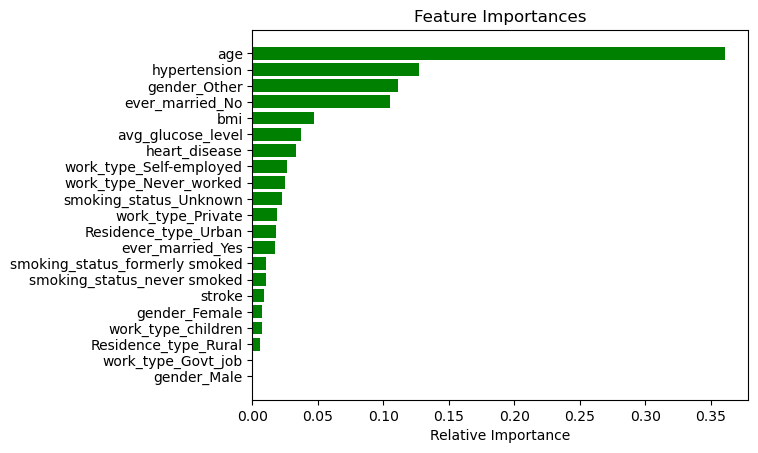

In [78]:
importances = final_rf.feature_importances_
indices = np.argsort(importances)
features = healthcare_ohe.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [79]:
knn_c = KNeighborsClassifier()
knn_c.fit(X_resampled, y_resampled)

KNeighborsClassifier()

Model na zbalansowanych danych

In [80]:
knn_c2 = KNeighborsClassifier()
knn_c2.fit(X_train, y_train)

KNeighborsClassifier()

Model na niezbalansowanych danych

In [81]:
print(scorer(knn_c))
print(scorer(knn_c2))

Predykcje na zbiorze testowym:
[[673 138]
 [  8 742]] 
Accuracy: 0.9064702114029468 
F1: 0.9104294478527607
Predykcje na zbiorze treningowym:
[[2728  362]
 [   9 3142]] 
Accuracy: 0.9405543983336004 
F1: 0.944252441773103
None
Predykcje na zbiorze testowym:
[[811   0]
 [688  62]] 
Accuracy: 0.5592568866111467 
F1: 0.15270935960591134
Predykcje na zbiorze treningowym:
[[3088    2]
 [2856  295]] 
Accuracy: 0.5420605672167922 
F1: 0.17111368909512759
None


Sprawdzamy wyniki dla różnych wartości parametru n_neighbors:

In [82]:
from sklearn import metrics
mean_f1 = np.zeros(20)
mean_acc = np.zeros(20)
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_resampled,y_resampled)
    y_pred= knn.predict(X_test)
    mean_f1[i-1] = metrics.f1_score(y_test, y_pred)
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)

print(pd.DataFrame(mean_f1, mean_acc))

                 0
0.954516  0.954341
0.950673  0.949902
0.929532  0.930991
0.932095  0.932911
0.906470  0.910429
0.912236  0.915380
0.893017  0.899215
0.896861  0.902009
0.887892  0.895021
0.890455  0.897050
0.878924  0.887433
0.880846  0.888756
0.868674  0.879056
0.872518  0.882179
0.862268  0.873900
0.866111  0.876841
0.852018  0.865932
0.855221  0.868145
0.846252  0.861272
0.849455  0.863610


Najlepsze wyniki dla k=1

In [83]:
knn_c_final = KNeighborsClassifier(n_neighbors = 1)
knn_c_final.fit(X_resampled, y_resampled)

KNeighborsClassifier(n_neighbors=1)

In [84]:
scorer(knn_c_final)

Predykcje na zbiorze testowym:
[[748  63]
 [  8 742]] 
Accuracy: 0.9545163356822549 
F1: 0.9543408360128618
Predykcje na zbiorze treningowym:
[[3090    0]
 [   0 3151]] 
Accuracy: 1.0 
F1: 1.0


In [85]:
svm_model = svm.SVC(class_weight='balanced', max_iter=10000)

In [86]:
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 10000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [87]:
search_grid = [
   {'C': [0.05, 0.07, 0.08, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 3, 5, 7, 10, 20, 50, 100], 'kernel': ['linear', 'poly', "rbf"]}
 ]
search_func = GridSearchCV(estimator=svm_model,
                           param_grid=search_grid,
                           scoring=scorer,
                           refit='f1',
                           cv=5)

In [88]:
search_func.fit(X_resampled, y_resampled)

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() tak

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: scorer() takes 1 positional argument but 3 were given

  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\s

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', max_iter=10000),
             param_grid=[{'C': [0.05, 0.07, 0.08, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2,
                                3, 5, 7, 10, 20, 50, 100],
                          'kernel': ['linear', 'poly', 'rbf']}],
             refit='f1', scoring=<function scorer at 0x0000029F109FC180>)

In [89]:
print(search_func.best_estimator_)
print(search_func.best_params_)
print(search_func.best_score_)

SVC(C=0.05, class_weight='balanced', kernel='linear', max_iter=10000)
{'C': 0.05, 'kernel': 'linear'}
nan


In [90]:
svm_final = svm.SVC(C=0.05, class_weight='balanced', kernel='linear', max_iter=10000)
svm_final.fit(X_resampled, y_resampled)

SVC(C=0.05, class_weight='balanced', kernel='linear', max_iter=10000)

In [91]:
scorer(svm_final)

Predykcje na zbiorze testowym:
[[599 212]
 [129 621]] 
Accuracy: 0.7815502882767457 
F1: 0.7845862286797222
Predykcje na zbiorze treningowym:
[[2277  813]
 [ 480 2671]] 
Accuracy: 0.7928216631950008 
F1: 0.8051243406179351


Najlepsze wyniki otrzymaliśmy wykorzystując model KNeighborsClassifier z parametrem n_neighbors = 1. 

In [93]:
model_final = knn_c_final
scorer(model_final)

Predykcje na zbiorze testowym:
[[748  63]
 [  8 742]] 
Accuracy: 0.9545163356822549 
F1: 0.9543408360128618
Predykcje na zbiorze treningowym:
[[3090    0]
 [   0 3151]] 
Accuracy: 1.0 
F1: 1.0
